TUTORIAL FROM SON OF A CORNER
https://www.sonofacorner.com/shot-maps-a-matplotlib-tutorial/

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

In [18]:
df = pd.read_csv("/Users/andylyford/Desktop/PROJECTS/Football/data/efl_championship_shots_07022022.csv")
df.head()

,Unnamed: 0,matchId,playerName,playerId,min,x,y,shotType,blocked,onTarget,xG,xGOT,eventType,teamId,teamColor,date,teamName
0,0,3414536,Cauley Woodrow,282276,4,93.699997,14.260383,RightFoot,False,False,0.0609,NaN,Miss,8283,#881018,2020-09-12 16:00:00,Barnsley
1,1,3414536,Alex Mowatt,488624,10,77.304371,25.996250,LeftFoot,False,False,0.0280,NaN,Miss,8283,#881018,2020-09-12 16:00:00,Barnsley
2,2,3414536,James Collins,189075,18,95.061402,37.050000,LeftFoot,False,False,0.2792,NaN,Miss,8346,#002858,2020-09-12 16:00:00,Luton Town
3,3,3414536,Alex Mowatt,488624,25,83.498545,33.771251,RightFoot,True,True,0.0281,NaN,AttemptSaved,8283,#881018,2020-09-12 16:00:00,Barnsley
4,4,3414536,Callum Styles,748856,25,94.578946,48.975287,LeftFoot,False,False,0.0324,NaN,Miss,8283,#881018,2020-09-12 16:00:00,Barnsley


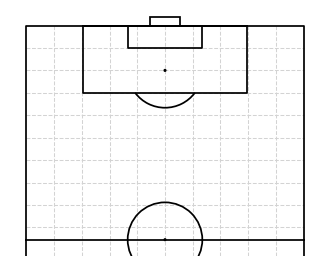

In [19]:
def soc_pitch_divisions(ax, grids = False):
    '''
    This function returns a vertical football pitch
    divided in specific locations.

    Args:
        ax (obj): a matplotlib axes.
        grids (bool): should we draw the grid lines?
    '''

    # Notice the extra parameters passed to the object
    pitch = VerticalPitch(
        pitch_type = "uefa",
        half = True,
        goal_type='box',
        linewidth = 1.25,
        line_color='black'
    )

    pitch.draw(ax = ax)

    # Where we'll draw the lines
    if grids:
        y_lines = [105 - 5.5*x for x in range(1,10)]
        x_lines = [68 - 6.8*x for x in range(1,10)]

        for i in x_lines:
            ax.plot(
                [i, i], [45, 105], 
                color = "lightgray", 
                ls = "--",
                lw = 0.75,
                zorder = -1
            )
        for j in y_lines:
            ax.plot(
                [68, 0], [j, j],
                color = "lightgray", 
                ls = "--",
                lw = 0.75,
                zorder = -1
            )

    return 

fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)

soc_pitch_divisions(ax, grids = True)

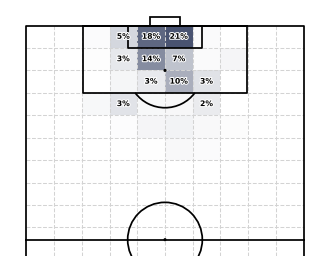

In [20]:
# Keep only most recent season data
df = df[df["date"] >= "2021-08-06"].reset_index(drop = True)

# We need to invert our coordinates
df.rename(columns = {"x":"y", "y":"x"}, inplace = True)

# We define the cuts for our data (same as our pitch divisions)
# Only difference is we need to add the edges

y_bins = [105] + [105 - 5.5*x for x in range(1,10)] + [45]
x_bins = [68] + [68 - 6.8*x for x in range(1,10)] + [0]

x_bins.sort()
y_bins.sort()

df["bins_x"] = pd.cut(df["x"], bins = x_bins)

df["bins_y"] = pd.cut(df["y"], bins = y_bins)

#Group and sum xGOT by side and location
df_teams = (
    df.groupby(
        ["bins_x", "bins_y", "teamName", "teamId", "teamColor"], 
        observed = True
    )["xGOT"].sum()
    .reset_index()
)

# And we sort it based on the bins_y and bins_x columns
df_teams = (
    df_teams.
    sort_values(by = ["bins_y", "bins_x"]).
    reset_index(drop = True)
)


example_df = df_teams[df_teams["teamName"] == "Luton Town"]
total_example = example_df["xGOT"].sum()

# Compute share of xGOT as a % of total
example_df = (
    example_df
    .assign(xGOT_share = lambda x: x.xGOT/total_example)
)
# Scale data to the maximum value to get a nice color scale
example_df = (
    example_df
    .assign(xGOT_scaled = lambda x: x.xGOT_share/x.xGOT_share.max())
)

fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)

soc_pitch_divisions(ax, grids = True)

counter = 0
for X, Y in zip(example_df["bins_x"], example_df["bins_y"]):
	#This colours our bins
    ax.fill_between(
        x = [X.left, X.right],
        y1 = Y.left,
        y2 = Y.right,
        color = "#495371",
        alpha = example_df["xGOT_scaled"].iloc[counter],
        zorder = -1,
        lw = 0
    )
	
    # Fancy annotations cuz why not?
    if example_df['xGOT_share'].iloc[counter] > .02:
        text_ = ax.annotate(
            xy = (X.right - (X.right - X.left)/2, Y.right - (Y.right - Y.left)/2),
            text = f"{example_df['xGOT_share'].iloc[counter]:.0%}",
            ha = "center",
            va = "center",
            color = "black",
            size = 5.5,
            weight = "bold",
            zorder = 3
        )

        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()]
        )

    counter += 1

In [21]:
def soc_xGOT_plot(ax, grids, teamId, data = df_teams):
    '''
    This plots our shot heat map based on the grids defined
    by the soc_pitch_divisions function.

    Args:
        ax (obj): a matplotlib Axes object.
        grids (bool): whether or not to plot the grids.
        teamId (int): the teamId of the side we wish to plot.
        data (pd.DataFrame): the data
    '''

    df = data.copy()
    df = data[data["teamId"] == teamId]
    total_xGOT = df["xGOT"].sum()

    df = (
        df
        .assign(xGOT_share = lambda x: x.xGOT/total_xGOT)
    )
    df = (
        df
        .assign(xGOT_scaled = lambda x: x.xGOT_share/x.xGOT_share.max())
    )

    soc_pitch_divisions(ax, grids = grids)

    counter = 0
    for X, Y in zip(df["bins_x"], df["bins_y"]):
        ax.fill_between(
            x = [X.left, X.right],
            y1 = Y.left,
            y2 = Y.right,
            color = "#495371",
            alpha = df["xGOT_scaled"].iloc[counter],
            zorder = -1,
            lw = 0
        )

        if df['xGOT_share'].iloc[counter] > .02:
            text_ = ax.annotate(
                xy = (X.right - (X.right - X.left)/2, Y.right - (Y.right - Y.left)/2),
                text = f"{df['xGOT_share'].iloc[counter]:.0%}",
                ha = "center",
                va = "center",
                color = "black",
                size = 6.5,
                weight = "bold",
                zorder = 3
            )

            text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.5, foreground="white"), path_effects.Normal()]
            )

        counter += 1
    
    return ax

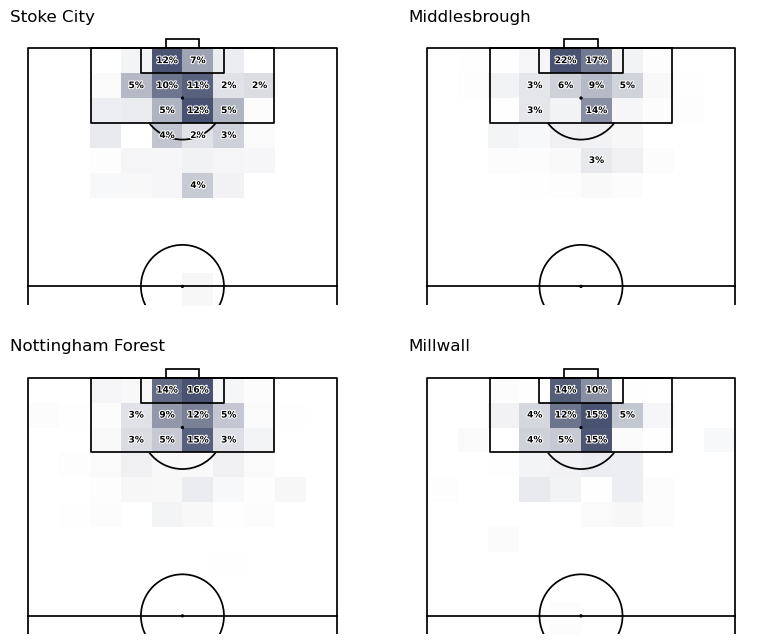

In [22]:
fig = plt.figure(figsize=(12, 8), dpi = 100)

ax_1 = plt.subplot(221)
ax_2 = plt.subplot(222)
ax_3 = plt.subplot(223)
ax_4 = plt.subplot(224)


soc_xGOT_plot(ax_1, False, 10194, data = df_teams)
soc_xGOT_plot(ax_2, False, 8549, data = df_teams)
soc_xGOT_plot(ax_3, False, 10203, data = df_teams)
soc_xGOT_plot(ax_4, False, 10004, data = df_teams)

ax_1.set_title("Stoke City", loc = 'left')
ax_2.set_title("Middlesbrough", loc = 'left')
ax_3.set_title("Nottingham Forest", loc = 'left')
ax_4.set_title("Millwall", loc = 'left')

plt.subplots_adjust(wspace = -.25)